# twixtools: Example Code

### Table of Contents
1. <a href='#section1'>`read_twix`: Direct access to the raw data</a>
2. <a href='#section2'>`map_twix`: high-level raw data access via a numpy-like twix-array</a>
3. <a href='#section3'>`map_twix`: EPI reconstruction example</a>
4. <a href='#section4'>`write_twix`: Writing modified data back to a twix file</a>


### Imports & helper functions

In [1]:
%matplotlib inline
import twixtools
import numpy as np
import matplotlib.pyplot as plt
import os

example_dir = '../example_data'

def ifftnd(kspace, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, ifftn
    if axes is None:
        axes = range(kspace.ndim)
    img = fftshift(ifftn(ifftshift(kspace, axes=axes), axes=axes), axes=axes)
    img *= np.sqrt(np.prod(np.take(img.shape, axes)))
    return img


def fftnd(img, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, fftn
    if axes is None:
        axes = range(img.ndim)
    kspace = fftshift(fftn(ifftshift(img, axes=axes), axes=axes), axes=axes)
    kspace /= np.sqrt(np.prod(np.take(kspace.shape, axes)))
    return kspace

def rms_comb(sig, axis=1):
    return np.sqrt(np.sum(abs(sig)**2, axis))

<a id='section1'></a>
## 1) `read_twix`: Direct access to the raw data

`read_twix` provides low-level access to the Siemens MRI raw data, on a block-by-block ("mdb") level.

    Parameters
    ----------
    infile : filename or measurement id of .dat file
    include_scans: list of scan numbers or None, optional
        By default, all scans in a multi-raid file are parsed.
    parse_prot : bool, optional
        By default, the protocol information is parsed.
        (this is also highly recommended)
    parse_data: bool, optional
        Set to False to parse only protocol information.
    parse_geometry: bool, optional
        Set to False to skip creation of transformation matrix from data
        coordinates to physical coordinates.
    verbose: bool, optional
        Switch progress and other messages on or off.
    keep_acqend : bool, optional
        By default, acqend blocks are not included in the mdb list.
        This block is helpful for twix writing, but unnecessary otherwise.
    keep_syncdata : bool, optional
        By default, syncdata blocks are included in the mdb list.
        These blocks may include physio. (PMU) or trajectory information.

    Returns
    -------
    out: list of twix scan(s)
        The twix scans themselves consist of a dict with these elements:
            - hdr: dict of parsed ascconv and XProtocol header information
            - hdr_str: header bytearray (used by write_twix)
            - mdb: list of measurement data blocks -- here is the MRI data
              use `help(twixtools.mdb.Mdb)` for more information
            - geometry: dict containing geometry information about the scan
              use `help(twixtools.geometry)` for more information


### Reconstructing an image from a twix file

In this example, we first parse the twix file using `read_twix`. The returned list of measurements only contains a single entry that includes data from a 2D Cartesian acquisition:

In [2]:
# parse the twix file
twix = twixtools.read_twix(os.path.join(example_dir, 'gre.dat'))

# twix is a list of measurements:
print('\nnumber of separate scans (multi-raid):', len(twix))

Software version: VD/VE (!?)

Scan  0


100%|██████████| 840k/840k [00:00<00:00, 74.7MB/s]


number of separate scans (multi-raid): 1


We can also obtain information about the acquisition, such as the repetition time (TR), from the sequence's protocol:

In [3]:
# access the protocol example: print the TR of the sequence
print('\nTR = %d ms\n'%(twix[-1]['hdr']['Phoenix']['alTR'][0]/1000))


TR = 10 ms



In addition to the protocol information, each measurement data block (mdb) contains information such as line counters and flags that indicate the type of the raw data (e.g. imaging scan or calibration scan), among other things.

Let's print the line counter and the acquisition flags for each 8th entry within the list of mdbs (printing every single line is a bit much, but try it if you like):

In [4]:
# list the mdh flags and line counters for every 8th measurement data block (mdb)
for mdb in twix[-1]['mdb'][::8]:
    print('line: %3d; flags:'%(mdb.cLin), mdb.get_active_flags())

line:   0; flags: ['ONLINE', 'FIRSTSCANINSLICE']
line:   8; flags: ['ONLINE']
line:  16; flags: ['ONLINE']
line:  24; flags: ['ONLINE']
line:  32; flags: ['ONLINE']
line:  40; flags: ['ONLINE']
line:  48; flags: ['ONLINE']
line:  56; flags: ['ONLINE']
line:  64; flags: ['ONLINE']
line:  72; flags: ['ONLINE']
line:  80; flags: ['ONLINE']
line:  88; flags: ['ONLINE']
line:  96; flags: ['ONLINE']
line: 104; flags: ['ONLINE']
line: 112; flags: ['ONLINE']
line: 120; flags: ['ONLINE']
line: 128; flags: ['ONLINE']
line: 136; flags: ['ONLINE']
line: 144; flags: ['ONLINE']
line: 152; flags: ['ONLINE']


And finally, let's read the data and reconstruct an image. To this end, we need to sort the raw data into a numpy array according to the mdb's line counter:


k-space shape (160, 2, 320)


(-0.5, 319.5, -0.5, 159.5)

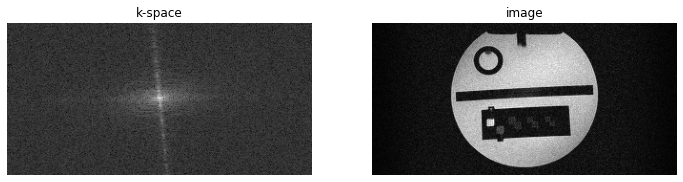

In [5]:
# sort all 'imaging' mdbs into a k-space array
image_mdbs = [mdb for mdb in twix[-1]['mdb'] if mdb.is_image_scan()]

n_line = 1 + max([mdb.cLin for mdb in image_mdbs])

# assume that all data were acquired with same number of channels & columns:
n_channel, n_column = image_mdbs[0].data.shape

kspace = np.zeros([n_line, n_channel, n_column], dtype=np.complex64)
for mdb in image_mdbs:
    kspace[mdb.cLin] = mdb.data

print('\nk-space shape', kspace.shape)

# reconstruct an image and show the result:
plt.figure(figsize=[12,8])
plt.subplot(121)
plt.title('k-space')
plt.imshow(abs(kspace[:,0])**0.2, cmap='gray', origin='lower')
plt.axis('off')

image = ifftnd(kspace, [0,-1])
image = rms_comb(image)
plt.subplot(122)
plt.title('image')
plt.imshow(abs(image), cmap='gray', origin='lower')
plt.axis('off')

\
After manually sorting the data into a k-space array, we can reconstruct a nice image. We notice that the field-of-view in read direction is twice as large as expected, since the raw data always includes an oversampling factor of two. However, this can be easily fixed by just cutting the FoV in image space accordingly.

<a id='section2'></a>
## 2) `map_twix`: high-level raw data access via a numpy-like twix-array
Using `map_twix`, we no longer need to sort the data into a k-space array ourselves: `map_twix` creates a `twix-array` object for each data type (image, noise adjust scan,...) it encounters within the file. The k-space matrix can then be accessed similar to a numpy ndarray, using numpy's slicing rules.

['Lin', 'Cha', 'Col']


(-0.5, 159.5, -0.5, 159.5)

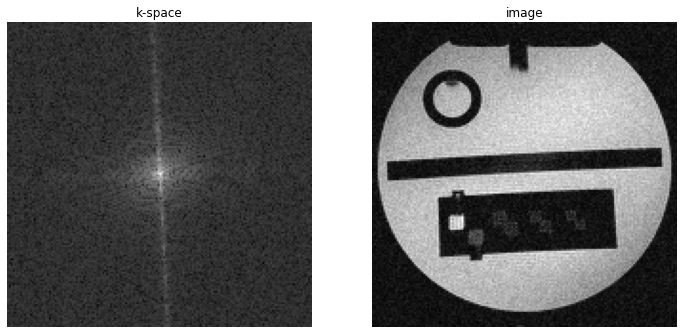

In [6]:
# map the twix data to twix_array objects
mapped = twixtools.map_twix(twix)
im_data = mapped[-1]['image']

# make sure that we later squeeze the right dimensions:
print(im_data.non_singleton_dims)

# the twix_array object makes it easy to remove the 2x oversampling in read direction
im_data.flags['remove_os'] = True

# read the data (array-slicing is also supported)
data = im_data[:].squeeze()

plt.figure(figsize=[12,8])
plt.subplot(121)
plt.title('k-space')
plt.imshow(abs(data[:,0])**0.2, cmap='gray', origin='lower')
plt.axis('off')

image = ifftnd(data, [0,-1])
image = rms_comb(image)
plt.subplot(122)
plt.title('image')
plt.imshow(abs(image), cmap='gray', origin='lower')
plt.axis('off')

<a id='section3'></a>
## 3) `map_twix`: EPI reconstruction example

Let's first run the reconstruction of the EPI data analogue to section 2 and see what happens:

Software version: VD/VE (!?)

Scan  0


100%|██████████| 229k/229k [00:00<00:00, 33.2MB/s]


(-0.5, 79.5, -0.5, 79.5)

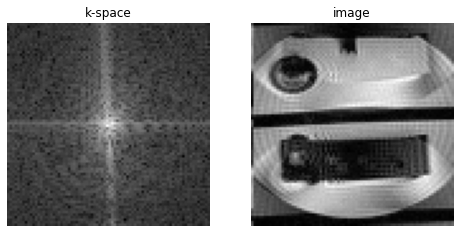

In [7]:
# map the twix data to twix_array objects
epi_map = twixtools.map_twix(os.path.join(example_dir, 'epi.dat'))

im_array = epi_map[-1]['image']
im_array.flags['remove_os'] = True

# read the data
data = im_array[:].squeeze()

# reconstruct the data
image = ifftnd(data, [0,-1])
image = rms_comb(image)

# plot the data

plt.figure(figsize=[8,6])
plt.subplot(121)
plt.title('k-space')
plt.imshow(abs(data[:,0])**0.2, cmap='gray', origin='lower')
plt.axis('off')

plt.subplot(122)
plt.title('image')
plt.imshow(image, cmap='gray', origin='lower')
plt.axis('off')

This does not look very good, what's wrong?

### Phase correction

EPI is usually sampled with alternating readout gradient polarity. Due to eddy currents and other time-delays, lines with opposite polarity are usually shifted with respect to one another. This effects leads to the characteristic "N/2" ghost in single-shot EPI (a low-intensity FoV/2 ghost appears on top of the imaged object).

To correct for this, it is common to acquire a phase-correction scan, that often consists of three non-phase-encoded EPI echoes. By averaging the two echoes with the same polarity and then comparing it to the third, it is possible to determine the shift between the echoes and correct for it.

Let's perform a simple auto-correlation based phase-correction:

(-0.5, 79.5, -0.5, 79.5)

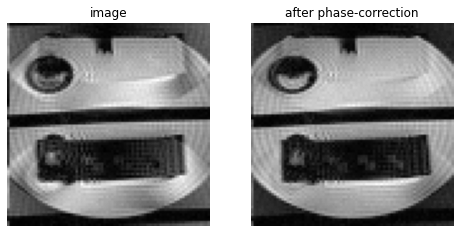

In [8]:
# functions to calculate & apply phase-correction:

def calc_pc_corr(sig):
    ncol = sig.shape[-1]
    
    # ifft col dim.
    pc = ifftnd(sig, [-1])
    
    # calculate phase slope from autocorrelation (for both readout polarities separately - each in its own dim)
    slope = np.angle((np.conj(pc[...,1:]) * pc[...,:-1]).sum(-1, keepdims=True).sum(-2, keepdims=True))
    x = np.arange(ncol) - ncol//2
    
    return np.exp(1j * slope * x)


def apply_pc_corr_and_ifft(sig, pc_corr):
    
    # ifft col dim.
    sig = ifftnd(sig, [-1])
    
    # apply phase-correction slope
    sig *= pc_corr
    
    # remove segment dim
    sig = sig.sum(5).squeeze()
    
    # ifft lin dim.
    sig = ifftnd(sig, [0])
    
    return sig


# for phase-correction, we need to keep the individual segments (which indicate the readout's polarity)
im_array.flags['remove_os'] = True
im_array.flags['average']['Seg'] = False

pc_array = epi_map[-1]['phasecorr']
pc_array.flags['remove_os'] = True
pc_array.flags['skip_empty_lead']=True
pc_array.flags['average']['Seg'] = False

# calculate phase-correction
pc_corr = calc_pc_corr(pc_array[:])

# apply phase-correction
image_pc = apply_pc_corr_and_ifft(im_array[:], pc_corr)

# RMS coil combination# plot results

image_pc = rms_comb(image_pc)

plt.figure(figsize=[8,6])
plt.subplot(121)
plt.title('image')
plt.imshow(image, cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(122)
plt.title('after phase-correction')
plt.imshow(image_pc, cmap='gray', origin='lower')
plt.axis('off')

The image certainly has improved, but it still looks distorted and "ringy" in the readout direction (left->right in this case).

### Ramp-sampling Regridding
The prominent artifacts in readout direction results from the fact that the EPI echo spacing was reduced during the data acquisition by overlapping the ramps of the readout gradient with the ADC. As a result, outer k-space is sampled more densely (i.e. on the ramp with reduced gradient amplitude), and overall the data no longer lie on a Cartesian grid. Thus, it is necessary to account for this by regridding the data.

`map_twix` already includes ramp-sampling regridding code that can be activated by setting the 'regrid' flag of the twix_array object to `True`.

So let's do that:

(-0.5, 79.5, -0.5, 79.5)

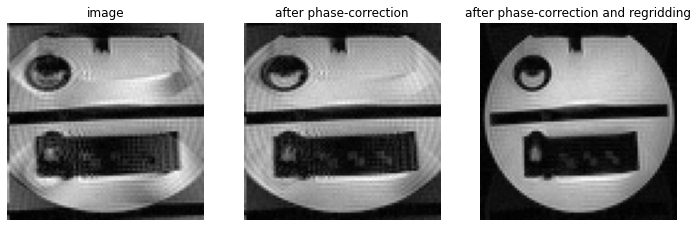

In [9]:
# activate regridding:
im_array.flags['regrid'] = True
pc_array.flags['regrid'] = True

# calculate phase-correction
pc_corr = calc_pc_corr(pc_array[:])

# apply phase-correction
image_pc_regrid = apply_pc_corr_and_ifft(im_array[:], pc_corr)

# RMS coil combination
image_pc_regrid = rms_comb(image_pc_regrid)

# plot results
plt.figure(figsize=[12,6])
plt.subplot(131)
plt.title('image')
plt.imshow(image, cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(132)
plt.title('after phase-correction')
plt.imshow(image_pc, cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(133)
plt.title('after phase-correction and regridding')
plt.imshow(image_pc_regrid, cmap='gray', origin='lower')
plt.axis('off')

This should look much better now!

<a id='section4'></a>
## 4) `write_twix`: Writing modified data back to a twix file
It is possible to modify data within the `Mdb` object list and then write it back to a twix file using the `write_twix`. Note that `write_twix` is highly experimental. However, in principle it should be possible to take the modified data back to the scanner and then run a retrospective reconstruction using the scanner's reconstruction system. Note that there is currently no tool that helps you to update protocol parameters in case you need to do that to for a successful retrospective reconstruction of the modified data (you can try to modify the `hdr_str` in the twix dict yourself, though, which will then be written to the new twix file together with the mdb data).

### Data manipulation: 
In this simple example, we will read the data from a fully-sampled 2D gradient-echo acquisition, modify the data, and then write it back to a twix file, so that we can bring it back to the scanner for a retrospective reconstruction.

#### Reconstructing the data
First let's read the data and map it to a twix_array object:

In [10]:
twix = twixtools.read_twix(os.path.join(example_dir, 'gre.dat'), keep_syncdata_and_acqend=True)
mapped = twixtools.map_twix(twix[-1])

Software version: VD/VE (!?)

Scan  0


100%|██████████| 840k/840k [00:00<00:00, 72.7MB/s]


\
Now read the image data and reconstruct an image for each coil element:

In [11]:
data = mapped['image'][0,0,0,0,0,0,0,0].squeeze()
image = ifftnd(data, [0,-1]) 

\
Here are images for the two coil elements (body coil with quadrature detection) as well as a rms combination:

(-0.5, 319.5, -0.5, 159.5)

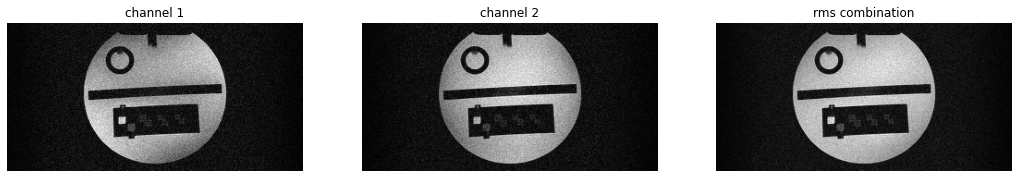

In [12]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.title('channel 1')
plt.imshow(abs(image[:,0]), cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(132)
plt.title('channel 2')
plt.imshow(abs(image[:,1]), cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(133)
plt.title('rms combination')
plt.imshow(rms_comb(image, 1), cmap='gray', origin='lower')
plt.axis('off')

\
As you can see, we did not bother to remove the 2x oversampling in read direction, since we want to write back the full data anyway.

#### Example I: Let's modify the line counter
In this first example, we flip the image upside down by modifying the line counter.

The line counter is stored as part of the "measurement data header" (mdh), together with other counters as well as other information, such as the current slice position and the timestamp of the acquisition.

Software version: VD/VE (!?)

Scan  0


100%|██████████| 840k/840k [00:00<00:00, 67.6MB/s]


(-0.5, 319.5, -0.5, 159.5)

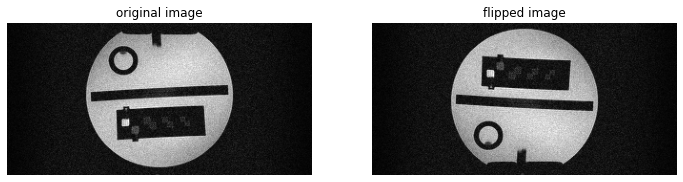

In [15]:
# make sure to start with a fresh 'twix' object
twix = twixtools.read_twix(os.path.join(example_dir, 'gre.dat'), keep_syncdata_and_acqend=True)
mapped = twixtools.map_twix(twix[-1])

# find maximum line number
maxlin = max([mdb.cLin for mdb in mapped['image'].mdb_list])

# now "flip" the line counters:
for mdb in mapped['image'].mdb_list:
    # all counters are stored in the mdh within "Counter"
    mdb.mdh.Counter.Lin = maxlin - mdb.mdh.Counter.Lin
    
# reconstruct the flipped image
data_flipped = mapped['image'][0,0,0,0,0,0,0,0].squeeze()
image_flipped = ifftnd(data_flipped, [0,-1]) 

# Let's compare the results:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('original image')
plt.imshow(rms_comb(image, 1), cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(122)
plt.title('flipped image')
plt.imshow(rms_comb(image_flipped, 1), cmap='gray', origin='lower')
plt.axis('off')

\
Of course, it would have been much easier to just flip the data within the `numpy.ndarray` data. However, by modifying the line counter, it is now possible to store the modification within a new twix file that can then be retrospectively reconstructed at the scanner: 

In [ ]:
try:
    # in case we have already run this once
    os.remove(os.path.join(example_dir, 'gre_flip.dat'))
except:
    pass
twixtools.write_twix(twix, os.path.join(example_dir, 'gre_flip.dat'))

#### Example II: Deleting data
In this second example, we simply delete every other line from the mdb list using the helper function `del_from_mdb_list`. For this, we need to define a rule in form of a lambda function.

In [ ]:
# make sure to start with a fresh 'twix' object
twix = twixtools.read_twix(os.path.join(example_dir, 'gre.dat'), keep_syncdata_and_acqend=True)

# delete every other line from k-space (2x undersampling)
twixtools.del_from_mdb_list(twix[-1]['mdb'], lambda mdb: mdb.is_image_scan() and mdb.cLin % 2)

\
Now we can write the data:

In [ ]:
try:
    # in case we have already run this once
    os.remove(os.path.join(example_dir, 'gre_del.dat'))
except:
    pass
twixtools.write_twix(twix, os.path.join(example_dir, 'gre_del.dat'))

#### Check the results
Let's read in the data from the original & manipulated file and compare the old to the new data:

In [ ]:
twix = twixtools.read_twix(os.path.join(example_dir, 'gre_del.dat'), keep_syncdata_and_acqend=True)
mapped = twixtools.map_twix(twix[-1])
data_new = mapped['image'][0,0,0,0,0,0,0,0].squeeze()

# reconstruct images
image_new = ifftnd(data_new, [0, -1])

# simple os-removal by index selection (for better visualization)
ix_k = slice(0, data.shape[-1], 2)
ix_im = slice(data.shape[-1]//4, (data.shape[-1]*3)//4)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('original k-space')
plt.imshow(abs(data[:,0,ix_k])**0.2, origin='lower')
plt.axis('off')
plt.subplot(222)
plt.title('undersampled k-space')
plt.imshow(abs(data_new[:,0,ix_k])**0.2, origin='lower')
plt.axis('off')
plt.subplot(223)
plt.title('original image')
plt.imshow(rms_comb(image[:,:,ix_im], 1), cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(224)
plt.title('undersampled image')
plt.imshow(rms_comb(image_new[:,:,ix_im], 1), cmap='gray', origin='lower')
plt.axis('off')

#### Example III: Manipulating the data
In this simple example, we just want to invert the image (you may already be familiar with this example).

Let's first find the maximum signal, which then defines the value range for inversion:

In [ ]:
max_val = abs(image).max()

\
Now apply the inversion and transform the image back to k-space:

In [ ]:
image_inv = max_val-abs(image)

# transform manipulated image back to k-space
data_inv = fftnd(image_inv, [0, -1])

#### Writing the Data
`write_twix` expects a list of mdbs (together with the protocol information) as input, so we first need to write our modified data to the original mdb list.

To this end, we first convert each imaging `Mdb` to a `Mdb_local` object, that allows for array manipulation. We then simply loop through the list, and then store the data for the current line counter.

In [ ]:
# make sure to start with a fresh 'twix' object
twix = twixtools.read_twix(os.path.join(example_dir, 'gre.dat'), keep_syncdata_and_acqend=True)

# sort the manipulated data into the mdb list
for key, mdb  in enumerate(twix[-1]['mdb']):
    if mdb.is_image_scan():
        mdb = mdb.convert_to_local()
        mdb.data = np.complex64(data_inv[mdb.cLin])
        twix[-1]['mdb'][key] = mdb 

\
Now it's time to write the new file!

In [ ]:
try:
    # in case we have already run this once
    os.remove(os.path.join(example_dir, 'gre_inv.dat'))
except:
    pass
twixtools.write_twix(twix, os.path.join(example_dir, 'gre_inv.dat'))

#### Check the results
Let's read in the data from the original & manipulated file and compare the old to the new data:

In [ ]:
twix = twixtools.read_twix(os.path.join(example_dir, 'gre_inv.dat'), keep_syncdata_and_acqend=True)
mapped = twixtools.map_twix(twix[-1])
data_new = mapped['image'][0,0,0,0,0,0,0,0].squeeze()
image_new = ifftnd(data_new, [0, -1])

ix_im = slice(data.shape[-1]//4, (data.shape[-1]*3)//4)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('original image')
plt.imshow(rms_comb(image[:,:,ix_im], 1), cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(122)
plt.title('manipulated image')
plt.imshow(rms_comb(image_new[:,:,ix_im], 1), cmap='gray', origin='lower')
plt.axis('off')